**Inviscid Burgers’ Equation**

For a given field $u(x, t)$ and diffusion coefficient (or kinematic viscosity, as in the original fluid mechanical context)  $\nu$ , the general form of Burgers' equation (also known as viscous Burgers' equation) in one space dimension is the dissipative system:

$$\frac{\partial u}{\partial t}+u \frac{\partial u}{\partial x}=\nu \frac{\partial^{2} u}{\partial x^{2}}$$ 

When the diffusion term is absent (i.e.  $\nu$=0  ), Burgers' equation becomes the inviscid Burgers' equation:

$$\frac{\partial u}{\partial t}+u \frac{\partial u}{\partial x}=0$$

which is a prototype for conservation equations that can develop discontinuities (shock waves). The previous equation is the advective form of the Burgers equation. conservative form is found to be more useful in numerical integration

$$\frac{\partial u}{\partial t}+\frac{1}{2} \frac{\partial\left(u^{2}\right)}{\partial x}=0$$




Inviscid Burgers' equation is a special case of nonlinear wave equation where wave speed  $c(u)=   u $. The inial value problem in this case can be posed as

\begin{array}{c}
\frac{\partial u}{\partial t}+u \frac{\partial u}{\partial x}=0, (x,t)∈[0,1] × [0,1]  \\
u(x, 0)=F(x)=x, x∈[0,1]\\
u(x,t) = g(x,t) = \frac{x}{t+1}, x ∈ \{0, 1\}
\end{array}


## 1.Setup

In [4]:
import torch
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from math import *
import time
import copy
import seaborn as sns


# %%
torch.set_default_tensor_type('torch.DoubleTensor')

In [2]:
# check pytorch version
print(torch.__version__)

1.13.0



## 2.Hyperparameter

In [3]:
dimension = 2
input_width,layer_width = dimension, 4
layer_depth = 5


## 3.Neural Architecture

In [4]:
# %%
# activation function
def activation(x):
    return x * torch.sigmoid(x)

class Net(torch.nn.Module):
    def __init__(self,input_width,layer_width,layer_depth):
        super(Net,self).__init__()
        self.layer_in = torch.nn.Linear(input_width, layer_width)
        for i in range(layer_depth-1):
            setattr(self, 'layer'+str(i), torch.nn.Linear(layer_width, layer_width))
        self.layer_out = torch.nn.Linear(layer_width, 1)
    def forward(self,x,layer_depth):
        y = activation(self.layer_in(x))
        for i in range(layer_depth-1):
            y = activation(getattr(self, 'layer'+str(i))(y))
        output = self.layer_out(y)
        return output


${\rm N}(\vec{x}) := {\rm A}_{\rm 4}(\sigma{\rm A}_3({\sigma}{\rm A}_2({\sigma}{\rm A}_{\rm 1}(\vec{x}))))\ ,$, where

${\rm A}_{\rm 1}: \mathbb{R}^2{→}\mathbb{R}^w$, ${\rm A}_2: \mathbb{R}^w{→}\mathbb{R}^w$, ${\rm A}_3: \mathbb{R}^w{→}\mathbb{R}^w$, ${\rm A}_{\rm 4}: \mathbb{R}^w{→}\mathbb{R}$, 

note: there are $2w^2+6w+1$ parameters need to be trained in total in ${\rm N}(x)$

## 4.Training setup

### 4.1 Initialize the weights using Xavier normal initialization

In [5]:
# %%
# Xavier normal initialization for weights:
#             mean = 0 std = gain * sqrt(2 / fan_in + fan_out)
# zero initialization for biases
def initialize_weights(self):
    for m in self.modules():
        if isinstance(m,nn.Linear):
            nn.init.xavier_normal_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()

### 4.2 Define $u_0(x)$

$$ [0,1] {\ni} x {↦} u_0(x) = x{∈} {\mathbb R} $$

In [6]:
# Define u_0
def u_0x(X):
    x = X[:,0]
    temp1 = x
    u_temp = temp1
    return u_temp.reshape([X.size()[0], 1])

### 4.3 Define the exact solution

$$[0,1]{×}[0,1]{\ni}(x, t) {↦} u(x, t) =\frac{x}{t+1} {∈} {\mathbb R}$$


In [7]:
# defination of exact solution
def u_ex(X):     
    x = X[:,0]
    t = X[:,1]
    
    temp1 = x/(t+1)
    u_temp = temp1
    return u_temp.reshape([x.size()[0], 1])

### 4.4 Define g(x,t)

$$ \{0,1\}×[0,1] \ni (x,t) ↦ g(x,t) = \frac{x}{t+1} ∈ {\mathbb R}$$

In [8]:
def g_x(X):     
    
    x = X[:,0]
    t = X[:,1]
    temp1 = x/(t+1)
    u_temp = temp1
    return u_temp.reshape([x.size()[0], 1])

In [9]:
def g_0x(X):
    x = torch.zeros([X.shape[0],1])[:,0]
    x.requires_grad = True
    t = X[:,1]
    temp1 = x/(t+1)
    u_temp = temp1
    return u_temp.reshape([x.size()[0], 1])

In [10]:
def g_1x(X):
    x = torch.ones([X.shape[0],1])[:,0]
    x.requires_grad = True
    t = X[:,1]
    temp1 = x/(t+1)
    u_temp = temp1
    return u_temp.reshape([x.size()[0], 1])

### 4.4 Build the model

$x = {\vec X}[:,0]$

$t = {\vec X}[:,1]$

Model for training on initial and boundary:$${\rm model}({x,t}) := {\rm N}(x, t)  $$
Model for training on boundary:$${\rm model}({x,t}) := {\rm N}(x, t) ⋅ x ⋅ (1-x)  +  (1-x) ⋅ g(0,t) + x{⋅} g(1,t)$$
Model for training on initial:$${\rm model}({x,t}) := {\rm N}(x, t)  ⋅ t  +  u_0(x) \cdot (1-t)$$



In [11]:
def model(X,initial = False, boundary = False):
    x = X[:,0]
    t = X[:,1].reshape([x.size()[0], 1])
    x_temp = x.reshape([x.size()[0], 1])
    t_temp = t.reshape([t.size()[0], 1])
    x_minus = (1.0-x).reshape([x.size()[0], 1])
    t_minus = (1.0-t).reshape([t.size()[0], 1])

    if initial == False and boundary == False:
        term1 = net(X,layer_depth)
        model_u_temp = term1
    elif initial == False and boundary == True:
        term1 = net(X,layer_depth) * x_temp * x_minus
        term2 = g_0x(X) * x_minus
        term3 = g_1x(X) * x_temp
        model_u_temp =  term1 + term2 + term3
    else:
        term1 = net(X,layer_depth) * t
        term2 = u_0x(X) * t_minus
        model_u_temp =  term1 + term2 
                   
    return model_u_temp.reshape([x.size()[0], 1])

#### 4.5.1 $ν_1$ generator

Generate random points $(x_n, t_n)$ from $[0,1] × [0,1]$

In [12]:
# generate points by random
def generate_sample_one(data_size):
    sample_temp = torch.rand(data_size, dimension)
    sample_temp.requires_grad = True
    return sample_temp

#### 4.5.2 $ν_2$ generator

Generate random points $x_n$ from $[0,1]$

In [12]:
def generate_sample_two(data_size):
    sample_temp = torch.rand(data_size, dimension)
    sample_temp[:,1] = 0
    sample_temp.requires_grad = True
    return sample_temp

#### 4.5.3 $ν_3$ generator

Generate random points $t_n$ from $[0,1]$,when $x_n=0$ or $x_n=1$

In [13]:
def generate_sample_three(data_size):
    sample_temp = torch.rand(data_size, dimension)
    # half of the first column is 0
    sample_temp[:int(data_size/2),0] = 0
    # half of the first column is 1
    sample_temp[int(data_size/2):,0] = 1
    sample_temp.requires_grad = True
    return sample_temp

### 4.6 Define Loss function

Loss for training on initial and boundary:$$Loss(û) = ||{\frac{∂û}{∂t}} +  \hat{u} {\frac{∂û}{∂x}}||^2_{[0,1]{×}{[0,1]},{ν_1}} +||û-F(x)||^2_{t=0,[0,1], ν_2} + ||û-g(x,t)||^2_{\{0,1\}{×}{[0,1]}, ν_3}$$
Loss for training on boundary:$$Loss(û) = ||{\frac{∂û}{∂t}} +  \hat{u} {\frac{∂û}{∂x}}||^2_{[0,1]{×}{[0,1]},{ν_1}} +||û-F(x)||^2_{t=0,[0,1], ν_2} $$

Loss for training on initial:$$Loss(û) = ||{\frac{∂û}{∂t}} +  \hat{u} {\frac{∂û}{∂x}}||^2_{[0,1]{×}{[0,1]},{ν_1}} + ||û-g(x,t)||^2_{\{0,1\}{×}{[0,1]}, ν_3}$$



In [14]:
# %%
# loss function to DGM by auto differential
def loss_function(x1, x2, x3, initial=False, boundary=False):
    # first term
    u_hat = model(x1,initial, boundary)
    grad_u_hat = torch.autograd.grad(outputs = u_hat, inputs = x1, grad_outputs = torch.ones(u_hat.shape), create_graph = True)  # dx and dt
    dx = grad_u_hat[0][:, 0]  # dx
    dt = grad_u_hat[0][:, 1]  # dt
    loss1 = torch.sum((dt + torch.multiply(u_hat.T,dx))**2) / len(x1)

    bias = torch.square(torch.mean(dt + torch.multiply(u_hat.T,dx)))
    variance = torch.mean(torch.square(dt + torch.multiply(u_hat.T,dx) - torch.mean(dt + torch.multiply(u_hat.T,dx))))
    #second term
    if initial == False:
        u_hat2 = model(x2,initial, boundary)
        u0 = u_0x(x2)
        loss2 = torch.sum((u_hat2 - u0) **2) / len(x2)
    else:
        loss2 = 0

    #third term

    if boundary == False:
        u_hat3 = model(x3,initial, boundary)
        u_ex3 = g_x(x3)
        loss3 = torch.sum((u_hat3 - u_ex3) **2) / len(x3)
    else:
        loss3 = 0
    return loss1 + loss2 + loss3
    # return loss

## 5.Doing the training

In [15]:
dimension = 2
input_width,layer_width = dimension, 4
layer_depth = 2

# Testing data
test_data = torch.zeros((101, 101, 2))
for i in range(101):
  x_test = i / 100
  for j in range(101):
    t_test = j / 100
    test_data[i][j][0] = x_test
    test_data[i][j][1] = t_test
test_data = torch.reshape(test_data, (101*101, 2))


def cal_error(x,initial = True, boundary = True):
    u_hat = model(x,initial, boundary)
    u = u_ex(x)
    error = ((u_hat - u).norm(2))**2 / (u.norm(2))**2
    return error

In [7]:
def plot_loss_epoch(loss_record_all, error_record_all,epoch, var_loss, var_error,layer_width):
    para = 2 * layer_width * layer_width + 6 * layer_width + 1
    fig = plt.figure()
    # Set subplots size
    fig.set_figheight(15)
    fig.set_figwidth(20)

    ax = fig.add_subplot(2, 1, 1)
    # plot a smooth curve of loss
    ax.plot(np.arange(epoch), loss_record_all[0])
    ax.plot(np.arange(epoch), loss_record_all[1])
    ax.plot(np.arange(epoch), loss_record_all[2])
    # append error bar to the plot 
    ax.errorbar(np.arange(epoch), loss_record_all[0], yerr=var_loss[0], label='vanilla')
    ax.errorbar(np.arange(epoch), loss_record_all[1], yerr=var_loss[1], label='boundary-included')
    ax.errorbar(np.arange(epoch), loss_record_all[2], yerr=var_loss[2], label='initial-included')

    ax.set_xlabel('epoch')
    ax.set_ylabel('Empirical loss')
    ax.set_title("Empirical loss for 1D Burgers' equation, epoch = 30000, Parameters: {}, lr = 0.0001, data_size = 3000".format(para))
    ax.set_yscale("log")
    ax.legend()

    ax = fig.add_subplot(2, 1, 2)
    # plot a smooth curve of loss
    ax.plot(np.arange(epoch), error_record_all[0])
    ax.plot(np.arange(epoch), error_record_all[1])
    ax.plot(np.arange(epoch), error_record_all[2])
    # append error bar to the plot
    ax.errorbar(np.arange(epoch), error_record_all[0], yerr=var_error[0], label='vanilla')
    ax.errorbar(np.arange(epoch), error_record_all[1], yerr=var_error[1], label='boundary-included')
    ax.errorbar(np.arange(epoch), error_record_all[2], yerr=var_error[2], label='initial-included')

    ax.set_xlabel('epoch')
    ax.set_ylabel('Fractional error w.r.t true solution')
    ax.set_title("Fractional error w.r.t true solution, epoch = 30000, Parameters: {}, lr = 0.0001,data_size = 3000".format(para))
    ax.set_yscale("log")
    ax.legend()

    plt.savefig('loss_epoch,1D, epoch = 30000, Parameters: {}, lr = 0.0001,data_size = 3000.png'.format(para))



In [ ]:
epoch = 30000
import pickle
layer_width_list = [4,40,200,300,1000,2000,3000]

for i in range(len(layer_width_list)):
  layer_width = layer_width_list[i]
  print("current layer width: {}".format(layer_width))
  loss_record_all = [[],[],[]]
  error_record_all = [[],[],[]]
  for i in range(5):
    print("current run: {}".format(i))
    net = Net(input_width,layer_width, layer_depth)
    initialize_weights(net)
    optimizer = optim.Adam(net.parameters())
    # %%
    loss_record = np.zeros(epoch)
    error_record = np.zeros(epoch)
    data_size = 3000
    x1 = generate_sample_one(data_size//3)
    x2 = generate_sample_two(data_size//3)
    x3 = generate_sample_three(data_size//3)
    time_start = time.time()
    for i in range(epoch):
        # scale_y[i] = float(model(scale_x))
        optimizer.zero_grad()
        loss = loss_function(x1, x2, x3, initial = False, boundary=False)
        loss_record[i] = float(loss)
        loss.backward()
        optimizer.step() 
        error_record[i] = cal_error(test_data, initial=False, boundary=False)
        torch.cuda.empty_cache() # clear memory
        print("Now epoch number is:{}".format(i),end='\r')
        if i % 2500 == 0:
          # y2.append(model(x2))
          print("current epoch is: ", i)
          print("current loss is: ", loss.detach())
    time_end = time.time()
    print('total time is: ', time_end-time_start, 'seconds')
    # plot_heatmap("venilla",initial=False, boundary=False)
    loss_record_all[0].append(loss_record)
    error_record_all[0].append(error_record)

    net = Net(input_width,layer_width, layer_depth)
    initialize_weights(net)
    optimizer = optim.Adam(net.parameters())
    # %%
    loss_record = np.zeros(epoch)
    error_record = np.zeros(epoch)
    time_start = time.time()
    for i in range(epoch):
        # scale_y[i] = float(model(scale_x))
        optimizer.zero_grad()
        loss = loss_function(x1, x2, x3, initial = False, boundary=True)
        loss_record[i] = float(loss)
        loss.backward()
        optimizer.step() 
        error_record[i] = cal_error(test_data, initial=False, boundary=True)
        torch.cuda.empty_cache() # clear memory
        print("Now epoch number is:{}".format(i),end='\r')
        if i % 2500 == 0:
          # y2.append(model(x2))
          print("current epoch is: ", i)
          print("current loss is: ", loss.detach())

    time_end = time.time()
    print('total time is: ', time_end-time_start, 'seconds')
    loss_record_all[1].append(loss_record)
    error_record_all[1].append(error_record)
    # plot_heatmap("boundary-included",initial=False, boundary=True)


    net = Net(input_width,layer_width, layer_depth)
    initialize_weights(net)
    optimizer = optim.Adam(net.parameters())
    # %%
    loss_record = np.zeros(epoch)
    error_record = np.zeros(epoch)
    time_start = time.time()
    for i in range(epoch):
        # scale_y[i] = float(model(scale_x))
        optimizer.zero_grad()
        loss = loss_function(x1, x2, x3, initial = True, boundary=False)
        loss_record[i] = float(loss)
        loss.backward()
        optimizer.step() 
        error_record[i] = cal_error(test_data, initial=True, boundary=False)
        torch.cuda.empty_cache() # clear memory
        print("Now epoch number is:{}".format(i),end='\r')
        if i % 2500 == 0:
          # y2.append(model(x2))
          print("current epoch is: ", i)
          print("current loss is: ", loss.detach())
    time_end = time.time()
    print('total time is: ', time_end-time_start, 'seconds')
    # plot_heatmap("initial-included",initial=True, boundary=False)
    loss_record_all[2].append(loss_record)
    error_record_all[2].append(error_record)

  with open('1D_burger_loss_record_all_{}.pkl'.format(layer_width), 'wb') as f:
      pickle.dump([loss_record_all,error_record_all], f)

  avg_loss_record = []
  avg_error_record = []

  var_error_record = []
  var_loss_record = []
  for i in range(len(loss_record_all)):
      avg_loss_record.append(np.mean(loss_record_all[i], axis=0))
      avg_error_record.append(np.mean(error_record_all[i], axis=0))
      var_error_record.append(np.var(error_record_all[i], axis=0))
      var_loss_record.append(np.var(loss_record_all[i], axis=0))

  print(var_error_record)
  plot_loss_epoch(avg_loss_record, avg_error_record, epoch,var_loss_record, var_error_record, layer_width)





current layer width: 4
current run: 0
current epoch is:  00
current loss is:  tensor(0.4199)
current epoch is:  25000
current loss is:  tensor(0.0017)
current epoch is:  50000
current loss is:  tensor(0.0002)
current epoch is:  75000
current loss is:  tensor(3.2582e-05)
current epoch is:  100000
current loss is:  tensor(1.0623e-05)
current epoch is:  125000
current loss is:  tensor(6.0348e-06)
current epoch is:  150000
current loss is:  tensor(4.1781e-06)
current epoch is:  175000
current loss is:  tensor(3.0185e-06)
current epoch is:  200000
current loss is:  tensor(2.3305e-06)
current epoch is:  225000
current loss is:  tensor(1.9170e-06)
current epoch is:  250000
current loss is:  tensor(1.6439e-06)
current epoch is:  275000
current loss is:  tensor(1.4572e-06)
total time is:  123.19652128219604 seconds
current epoch is:  00
current loss is:  tensor(0.0121)
current epoch is:  25000
current loss is:  tensor(3.7248e-06)
current epoch is:  50000
current loss is:  tensor(3.1198e-07)
cur

current epoch is:  125000
current loss is:  tensor(4.9339e-11)
current epoch is:  150000
current loss is:  tensor(3.3166e-11)
current epoch is:  175000
current loss is:  tensor(9.0415e-11)
current epoch is:  200000
current loss is:  tensor(5.6670e-09)
current epoch is:  225000
current loss is:  tensor(7.5397e-09)
current epoch is:  250000
current loss is:  tensor(1.0287e-11)
current epoch is:  275000
current loss is:  tensor(8.0259e-12)
total time is:  153.35732889175415 seconds
current epoch is:  00
current loss is:  tensor(0.1973)
current epoch is:  25000
current loss is:  tensor(0.0010)
current epoch is:  50000
current loss is:  tensor(0.0002)
current epoch is:  75000
current loss is:  tensor(4.9791e-05)
current epoch is:  100000
current loss is:  tensor(2.4326e-05)
current epoch is:  125000
current loss is:  tensor(1.8917e-05)
current epoch is:  150000
current loss is:  tensor(1.7366e-05)
current epoch is:  175000
current loss is:  tensor(1.6416e-05)
current epoch is:  200000
curre

current epoch is:  100000
current loss is:  tensor(3.2638e-06)
current epoch is:  125000
current loss is:  tensor(2.6232e-06)
current epoch is:  150000
current loss is:  tensor(1.6825e-06)
current epoch is:  175000
current loss is:  tensor(9.8147e-07)
current epoch is:  200000
current loss is:  tensor(4.1218e-07)
current epoch is:  225000
current loss is:  tensor(2.3609e-07)
current epoch is:  250000
current loss is:  tensor(1.6932e-07)
current epoch is:  275000
current loss is:  tensor(1.2808e-07)
total time is:  246.21527481079102 seconds
current run: 2
current epoch is:  00
current loss is:  tensor(0.5679)
current epoch is:  25000
current loss is:  tensor(3.6615e-05)
current epoch is:  50000
current loss is:  tensor(2.9986e-06)
current epoch is:  75000
current loss is:  tensor(2.0316e-05)
current epoch is:  100000
current loss is:  tensor(7.6618e-07)
current epoch is:  125000
current loss is:  tensor(3.7072e-07)
current epoch is:  150000
current loss is:  tensor(2.2142e-07)
current 

In [2]:
import pickle
with open('1D_burger_loss_record_all_1000.pkl', 'rb') as f:
    a = pickle.load(f)
loss_record_all = a[0]
error_record_all = a[1]

epoch = 30000


In [5]:

avg_loss_record = []
avg_error_record = []

var_error_record = []
var_loss_record = []
for i in range(len(loss_record_all)):
    avg_loss_record.append(np.mean(loss_record_all[i], axis=0))
    avg_error_record.append(np.mean(error_record_all[i], axis=0))
    var_error_record.append(np.var(error_record_all[i], axis=0))
    var_loss_record.append(np.var(loss_record_all[i], axis=0))


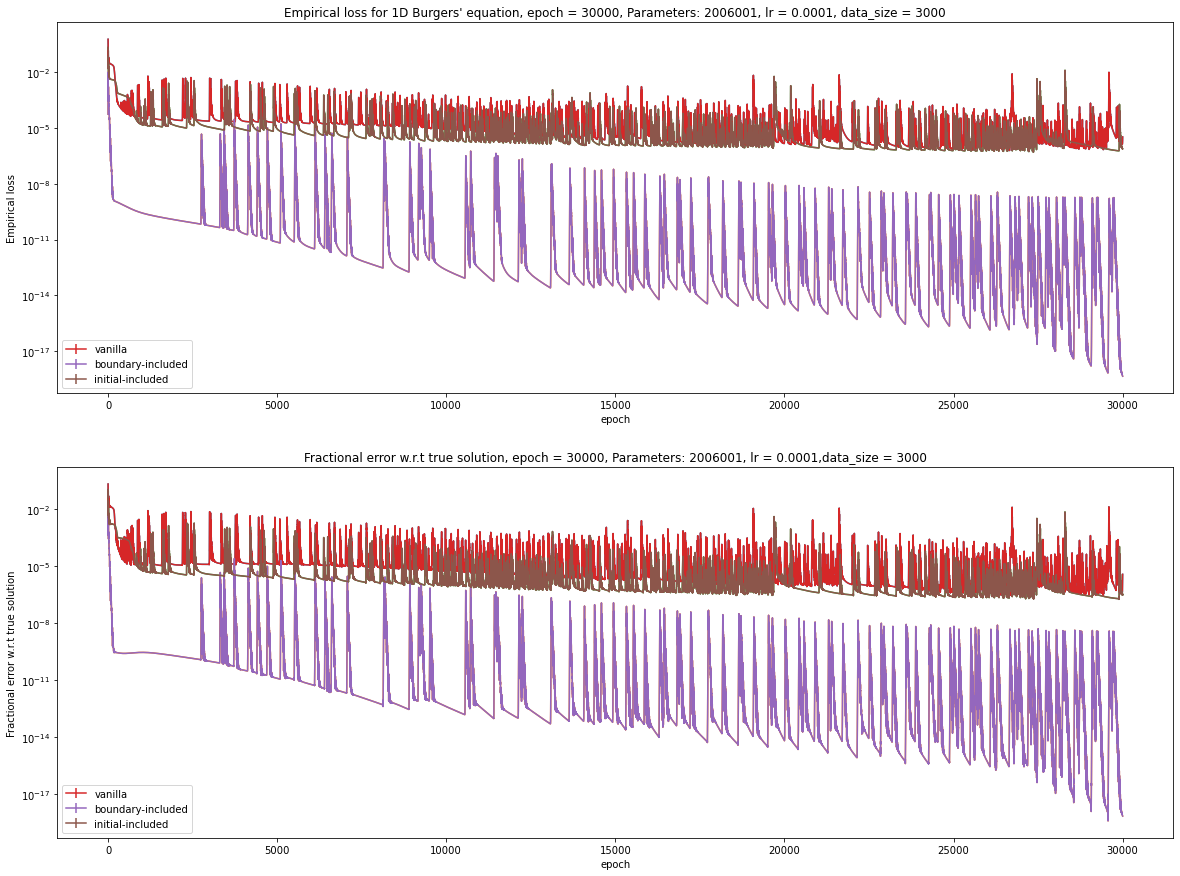

In [8]:
plot_loss_epoch(avg_loss_record, avg_error_record, epoch,var_loss_record, var_error_record,1000)